<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#LGBMModel" data-toc-modified-id="LGBMModel-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMModel</a></span></li><li><span><a href="#SGDRegressor" data-toc-modified-id="SGDRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>SGDRegressor</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Цели и задачи проекта

Цель прокта: для задачи оптимизации работы сервиса на основе исторических данных о заказах такси из аэропортов построить модель прогнозирования количества заказов такси на следующий час со средней ошибкой не более 48 заказов.

Задачи проекта:

1. Провести предобработку данных

2. Провести исследовательский анализ данных

3. Подготовить данные для обучения моделей

4. Построить несколько моделей и подобрать минимизирующие RMSE гиперпараметры

5. На основе метрики RMSE выбрать лучшую модель

6. Протестировать модель на тестовой выборке

7. Проверить модель на адекватность

# Описание даных

Признаки

`datetime` - дата и время с интервалом в 10 минут

Целевой признак

`num_orders` - количество заказов за временной интервал

## Предобработка данных

In [53]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [54]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
  
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import optuna 

from tqdm import tqdm

In [55]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


## Анализ

In [56]:
# проверка данных на монотонность
df.index.is_monotonic

True

In [57]:
# проверка наличия пропусков
df.isna().sum()

num_orders    0
dtype: int64

In [58]:
# ресемплируем данные в диапазон по 1 часу (т к прогнозирование требуется на следующий час)
df = df.resample('1H').sum()

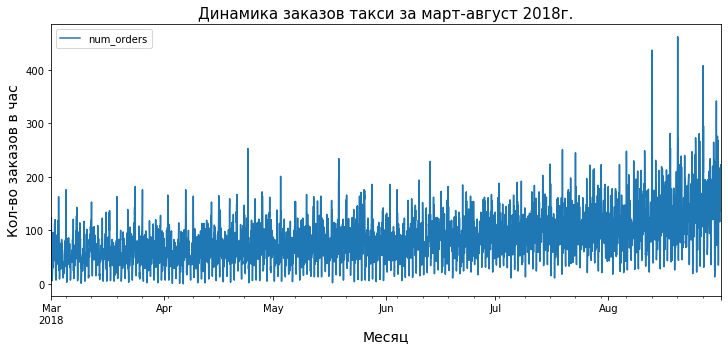

In [59]:
# распределение количества заказов по датам
df.sort_index(inplace=True)
df.plot(figsize=(12, 5))
plt.title('Динамика заказов такси за март-август 2018г.', size=15)
plt.xlabel('Месяц', size=14)
plt.ylabel('Кол-во заказов в час', size=14)
plt.show()

In [60]:
# описательные статистики количества заказов
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

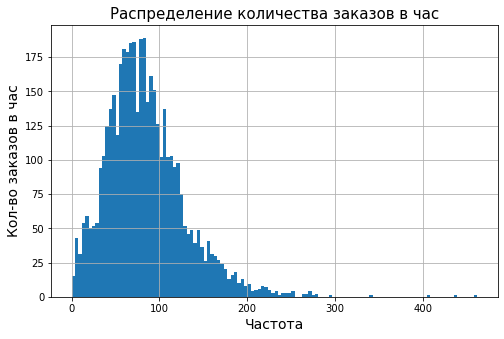

In [61]:
# распределение количества заказов
df['num_orders'].hist(figsize=(8, 5), bins=120)
plt.title('Распределение количества заказов в час', size=15)
plt.xlabel('Частота', size=14)
plt.ylabel('Кол-во заказов в час', size=14)
plt.show()

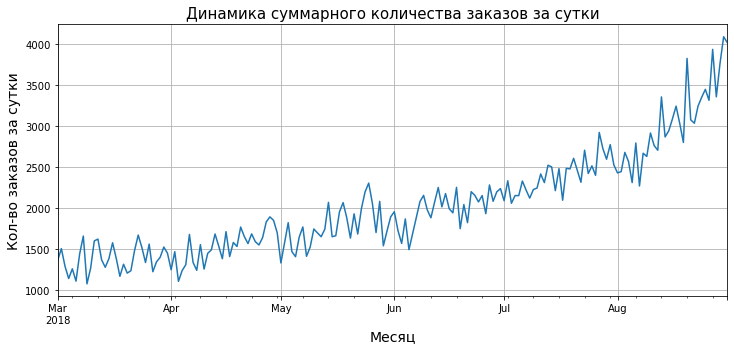

In [62]:
# динамика суммарного количества заказов в сутки
df['num_orders'].resample('1D').sum().plot(figsize=(12, 5), grid=True)
plt.title('Динамика суммарного количества заказов за сутки', size=15)
plt.xlabel('Месяц', size=14)
plt.ylabel('Кол-во заказов за сутки', size=14)
plt.show()

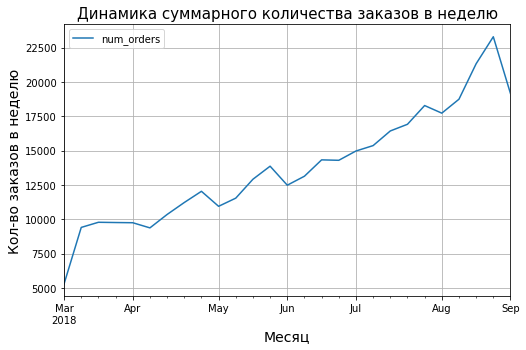

In [63]:
# динамика суммарного количества заказов в неделю
df.resample('1W').sum().plot(figsize=(8, 5), grid=True)
plt.title('Динамика суммарного количества заказов в неделю', size=15)
plt.xlabel('Месяц', size=14)
plt.ylabel('Кол-во заказов в неделю', size=14)
plt.show()

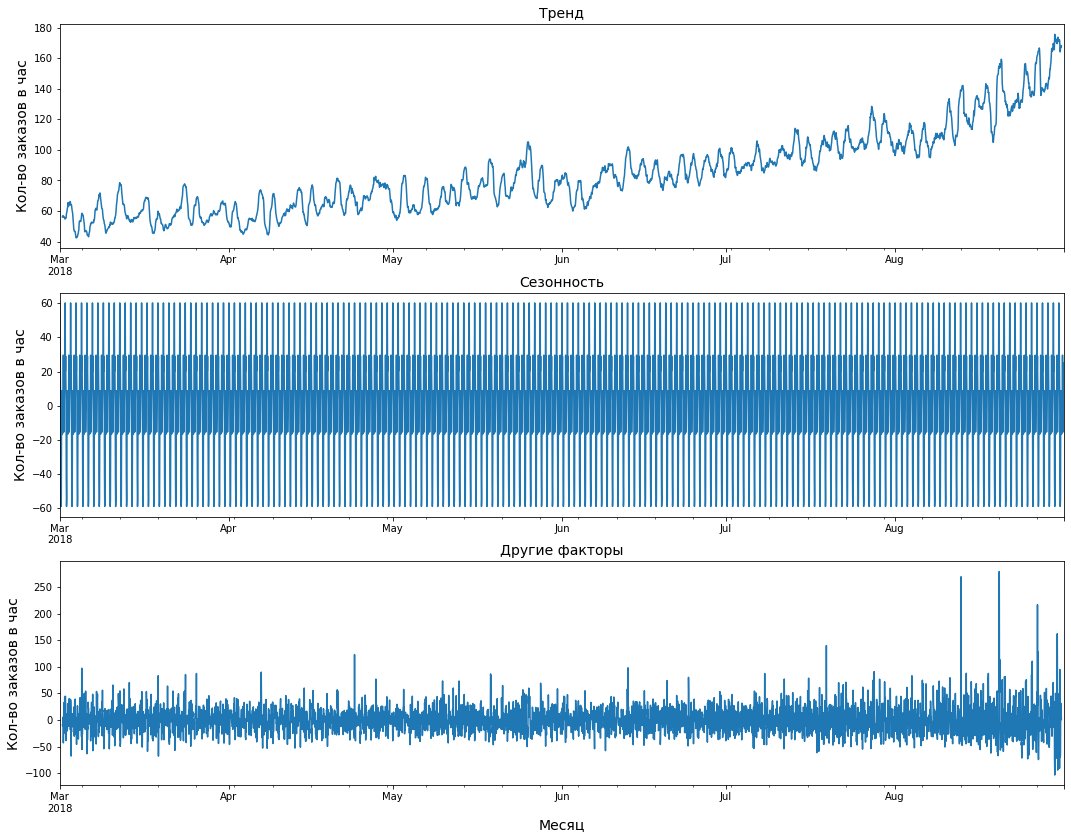

In [64]:
# декомпозиция кол-ва заказов на тренд, сезонность и остатки
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(18, 14))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca()) 

plt.title('Тренд', size=14)
plt.xlabel('')
plt.ylabel('Кол-во заказов в час', size=14)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность', size=14)
plt.xlabel('')
plt.ylabel('Кол-во заказов в час', size=14)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Другие факторы', size=14)
plt.xlabel('Месяц', size=14)
plt.ylabel('Кол-во заказов в час', size=14)
plt.show()

Есть восходящий тренд и остатки, но вклад годовой сезонности определить невозможно. 

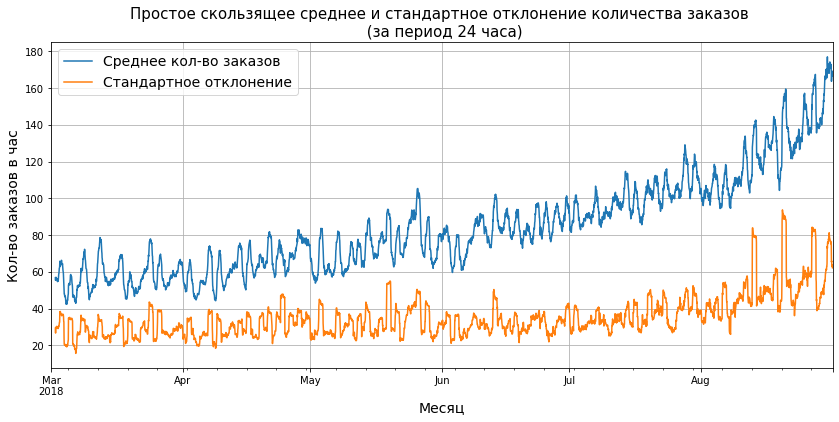

In [65]:
# скользящее среднее и стандартное отклонение за последние 24 часа
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df[['mean', 'std']].plot(figsize=(14, 6), grid=True)
plt.title('Простое скользящее среднее и стандартное отклонение количества заказов \n (за период 24 часа)', size=15)
plt.xlabel('Месяц', size=14)
plt.ylabel('Кол-во заказов в час', size=14)
plt.legend(['Среднее кол-во заказов', 'Стандартное отклонение'], fontsize=14)
plt.show()

Увеличивается и среднее значение, и волатильность (стандартное отклонение).

In [66]:
# удаляем признаки, которые в таком виде не будут использоваться для обучения моделей
df = df.drop(['std', 'mean'], axis=1)

Данные монотонны, пропусков не содержат, предствалены в диапазоне с марта по сентябрь 2018 года. 

В среднем каждый час заказывали по 84 машины, количества заказов расположены в диапазоне от 0 до 462 заказов, распределение количества заказов скошено вправо. 

К концу периода (август-сентябрь) наблюдается значительный рост заказов: в среднем с 55 в марте до 160 заказов в час в конце августа. Пиковые нагрузки также приходятся на август.

Оценить вклад годовой сезонности в количество заказов возможности нет (т.к. данные только за 6 месяцев), поэтому динамику объясняют восходящий тренд и остатки, объясняемые третьими факторами.

Ниже в функции добавления фичей закомментированы фичи, которые могли бы быть полезными, но результатов на работу моделей не оказали (по крайней мере на заданном временном промежутке).

In [67]:
# max_lag: предыдущее значение таргета от 1 до max_lag
# rolling_mean_size: размеры окна скользящего среднего (список значений: можно указать часовое, суточное и недельное)
# std_size: стандартное отклонение за последние std_size часов
# last_days_lag - за сколько предыдущих дней мы хотим получить среднее в целевой час

def make_features(data, max_lag, rolling_mean_size, std_size, last_days_lag):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    # перебор лагов
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # перебор окон для скользящего среднего
    for size in rolling_mean_size:
        data['rolling_mean_{}'.format(size)] = data['num_orders'].shift(1).rolling(size).mean()
    #  скользящее стандартное отклонение за последние 24 часа
    data['std'] = data['num_orders'].shift(1).rolling(std_size).std()
    # количество заказов в этот час в предыдущие сутки
    data['last_day'] = data['num_orders'].shift(24)
    # количество заказов в целевой час на предыдущей неделе в тот же день
    data['last_week'] = data['num_orders'].shift(168)
    data['last_days_mean'] = data['last_day']
    # среднее в целевой час за последние last_days_lag дней
    for day in range(2, last_days_lag + 1):
        data['last_days_mean'] = data['last_days_mean'] + data['num_orders'].shift(24*day)
    # берем среднее из получившейся суммы значений в целевой час за предыдущие дни
    data['last_days_mean'] = data['last_days_mean']/last_days_lag
    # час (для графика)
    data['hour'] = data.index.hour
    # удаляем строки с пропусками
    data = data.dropna()
    # приводим к целочисленному типу
    data = data.astype(int)
    # синус и косинус номера часа
    data['sin_hour'] = np.sin(2*np.pi*data.index.hour/24)
    data['cos_hour'] = np.cos(2*np.pi*data.index.hour/24)
    return data
    
df = make_features(df, 2, [24], 24, 3)
df.head(25)

,num_orders,month,dayofweek,lag_1,lag_2,rolling_mean_24,std,last_day,last_week,last_days_mean,hour,sin_hour,cos_hour
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,3,94,127,60,33,100,124,76,0,0.000000e+00,1.000000e+00
2018-03-08 01:00:00,78,3,3,143,94,61,36,121,85,124,1,2.588190e-01,9.659258e-01
2018-03-08 02:00:00,65,3,3,78,143,60,34,24,71,30,2,5.000000e-01,8.660254e-01
2018-03-08 03:00:00,68,3,3,65,78,61,33,66,66,55,3,7.071068e-01,7.071068e-01
2018-03-08 04:00:00,60,3,3,68,65,61,33,73,43,45,4,8.660254e-01,5.000000e-01
2018-03-08 05:00:00,6,3,3,60,68,61,33,10,6,20,5,9.659258e-01,2.588190e-01
2018-03-08 06:00:00,6,3,3,6,60,61,33,19,12,9,6,1.000000e+00,6.123234e-17
2018-03-08 07:00:00,19,3,3,6,6,60,34,17,15,13,7,9.659258e-01,-2.588190e-01
2018-03-08 08:00:00,77,3,3,19,6,60,34,38,34,31,8,8.660254e-01,-5.000000e-01


     
Добавленные признаки:
    
month - без указания месяца точность моделей на тесте на 1 ниже (35 вместо 34)       

std - модель действительно не улучшает (убрала его из обучения)
    
last_week - количество заказов в целевой час на предыдущей неделе в тот же день недели (явно улучшил модель)
    
last_days_lag - за сколько предыдущих дней мы хотим получить среднее в целевой час (явно улучшил модель), оптимально - среднее за 3 предыдущих дня по этому часу. Больше - можно поменять, но результат не улучшает.
    
max_lag - количество лагов более 2х никак не меняют результат (брала разные значения до 12 включительно) - ошибка не уменьшается

синус и косинус часа - в данном случае они качество не поменяли.

In [68]:
df


,num_orders,month,dayofweek,lag_1,lag_2,rolling_mean_24,std,last_day,last_week,last_days_mean,hour,sin_hour,cos_hour
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,3,94,127,60,33,100,124,76,0,0.000000,1.000000
2018-03-08 01:00:00,78,3,3,143,94,61,36,121,85,124,1,0.258819,0.965926
2018-03-08 02:00:00,65,3,3,78,143,60,34,24,71,30,2,0.500000,0.866025
2018-03-08 03:00:00,68,3,3,65,78,61,33,66,66,55,3,0.707107,0.707107
2018-03-08 04:00:00,60,3,3,68,65,61,33,73,43,45,4,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,4,207,217,164,65,72,113,117,19,-0.965926,0.258819
2018-08-31 20:00:00,154,8,4,136,207,167,63,142,179,142,20,-0.866025,0.500000
2018-08-31 21:00:00,159,8,4,154,136,168,63,198,166,185,21,-0.707107,0.707107


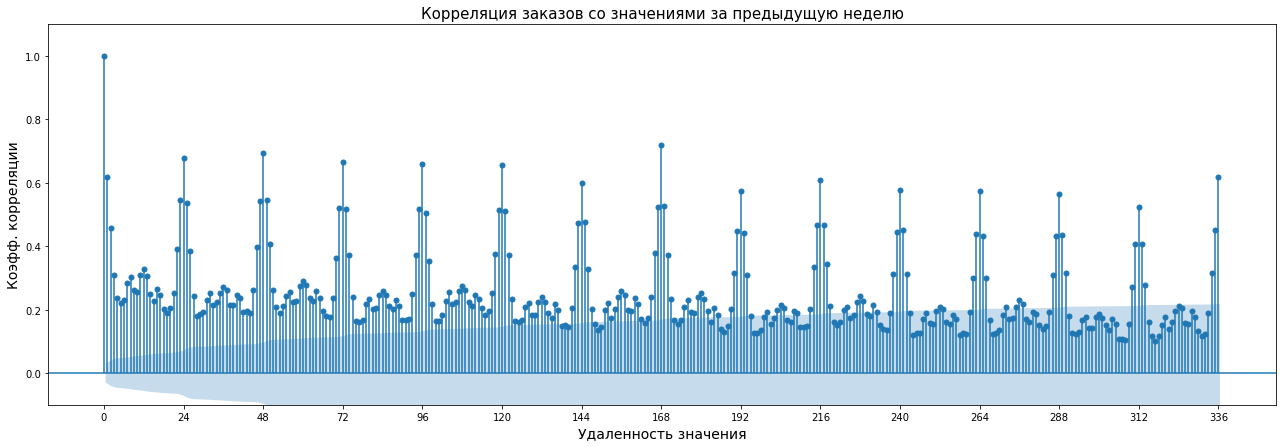

In [69]:
# корреляция с предыдущими 168 значениями
fig = tsaplots.plot_acf(df['num_orders'], lags= 336)
fig.set_size_inches(22, 7)
plt.ylim(-.1, 1.1)
plt.title('Корреляция заказов со значениями за предыдущую неделю', size=15)
plt.xlabel('Удаленность значения', size=14)
plt.ylabel('Коэфф. корреляции', size=14)
plt.xticks(ticks=range(0, 337, 24), labels=range(0, 337, 24))
plt.show()

Автокорреляция - мера линейной связи между числовой переменной и ею самой в другой момент времени.

Сильнее всего корреляция:

- с предыдущим значением

- со значением того же часа в предыдущие сутки (на 24, 48 и тд часов ранее)

- со значением того же часа в предыдущие сутки и в тот же день недели (на 168 часов раньше).

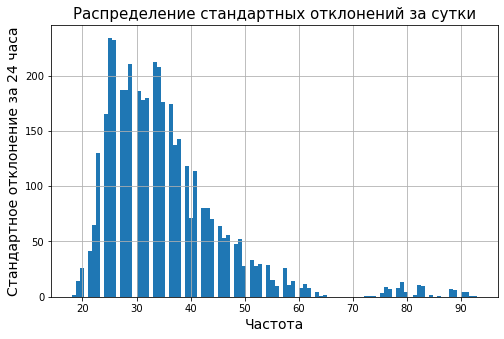

In [70]:
# распределение стандартных отклонений за сутки
df['std'].hist(bins=100, figsize=(8, 5))
plt.title('Распределение стандартных отклонений за сутки', size=15)
plt.xlabel('Частота', size=14)
plt.ylabel('Стандартное отклонение за 24 часа', size=14)
plt.show()

В среднем внутри суток цена отклоняется от среднего на 34, а 75% отклонений расположены диапазоне от 15 до 39. Также есть часть выбивающихся значений отклонений: сутки, когда отклонение превышало максимальный допустимый размер ошибки (48) и достигало 93.

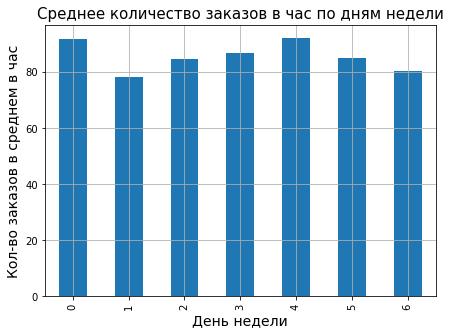

In [71]:
# изменение среднего количества заказов по дням недели
df.groupby(by='dayofweek')['num_orders'].mean().plot(grid=True, figsize=(7, 5), kind='bar')
plt.title('Cреднее количество заказов в час по дням недели', size=15)
plt.xlabel('День недели', size=14)
plt.ylabel('Кол-во заказов в среднем в час', size=14)
plt.show()

Внутри недели есть некоторые колебания средних значений, но не очень значительные.

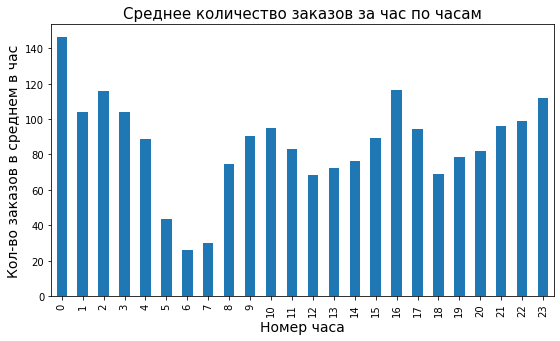

In [72]:
# изменение среднего количества заказов по часам
df.groupby(by='hour')['num_orders'].mean().plot(figsize=(9, 5), kind='bar')
plt.title('Cреднее количество заказов за час по часам', size=15)
plt.xlabel('Номер часа', size=14)
plt.ylabel('Кол-во заказов в среднем в час', size=14)
plt.show()

Внутри суток есть значительные колебания: сниижение в ночное время и рост в вечернее, в дневное время небольшие колебания вокруг значения 80 заказов в час.

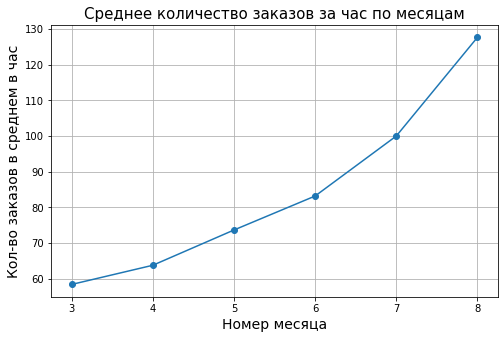

In [73]:
# изменение среднего количества заказов по месяцам
df.groupby(by='month')['num_orders'].mean().plot(grid=True, style='o-', figsize=(8, 5))
plt.title('Cреднее количество заказов за час по месяцам', size=15)
plt.xlabel('Номер месяца', size=14)
plt.ylabel('Кол-во заказов в среднем в час', size=14)
plt.show()

Среднемесячное количество заказов увеличивается.

In [74]:
# удаляем строки с пропусками
df = df.dropna()
# удаляем абсолютное значение часа
df = df.drop(['hour', 'std'], axis=1)
# обновляем индексы
df.reset_index(drop=True, inplace=True)
df.head()

,num_orders,month,dayofweek,lag_1,lag_2,rolling_mean_24,last_day,last_week,last_days_mean,sin_hour,cos_hour
0,143,3,3,94,127,60,100,124,76,0.000000,1.000000
1,78,3,3,143,94,61,121,85,124,0.258819,0.965926
2,65,3,3,78,143,60,24,71,30,0.500000,0.866025
3,68,3,3,65,78,61,66,66,55,0.707107,0.707107
4,60,3,3,68,65,61,73,43,45,0.866025,0.500000


Добавленные признаки:

- month - месяц

- dayofweek - день недели

- lag_1, lag_2, lag_3 - предыдущие значения с отставанием на один, два, три часа соответственно

- rolling_mean_24 - скользящее среднее за последние 24 часа

- last_day - количество заказов в этот час в предыдущие сутки

- last_day_delta - дельта между заказами в этот час в прошлые и позапрошлые сутки: на сколько в прошлые сутки заказов было больше, чем в позапрошлые

- sin_hour, cos_hour - синус и косинус часа

- last_week - количество заказов в целевой час на предыдущей неделе в тот же день недели

- last_days_mean - среднее в целевой час за последние 3 дня

In [75]:
# тест Дики-Фуллера для определения стационарного ряда 
print('P-Value: {}'.format(adfuller(df['num_orders'], regression='ctt')[1]))

P-Value: 1.3234680770930366e-16


P-Value очень низкий и при практически любом уровне значимости отвергнуть нулевую гипотезу о том, что ряд не стационарен, нельзя.

# 3 Препроцессинг

In [76]:
# сплит на датафрейм без целевого признака (features) и целевой признак (target)
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

# сплит на обучающую(81%), валидационную(9%) и тестовую (10%) выборки 
x_train, x_test, y_train, y_test = train_test_split(
    features, target, shuffle=False, test_size=0.10, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, shuffle=False, test_size=0.10, random_state=1)

## Обучение моделей

### LinearRegression

In [77]:
%%time

model = LinearRegression()

model.fit(x_train, y_train)
prediction = model.predict(x_val)

print("Средняя ошибка LinearRegression: - {:.0f}".format(mean_squared_error(y_val, prediction, squared=False)))

Средняя ошибка LinearRegression: - 30
CPU times: user 83.5 ms, sys: 7.98 ms, total: 91.4 ms
Wall time: 23.8 ms


### LGBMRegressor

In [78]:
 %%time
# подбор параметров n_estimators, num_leaves, bagging_fraction
# с параметром boosting_type = 'rf' - Случайный лес 
def objective(trial):      
    params={'boosting_type':'rf',
            'random_state':1,
            'bagging_freq': 1,
            'n_estimators':trial.suggest_int('n_estimators', 5, 100, step=10),
            'num_leaves':trial.suggest_int('num_leaves', 5, 100, step=10), 
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    model = lgb.LGBMRegressor(**params).fit(x_train, y_train, eval_metric="rmse")
    prediction = model.predict(x_val)
    rmse = mean_squared_error(y_val, prediction, squared=False)
    return rmse


study = optuna.create_study()
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-12-02 12:05:00,036] A new study created in memory with name: no-name-b6274ac9-84ae-4a4b-9f3a-caaff2f779aa


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:02,722] Trial 0 finished with value: 31.396138316719785 and parameters: {'n_estimators': 95, 'num_leaves': 45, 'bagging_fraction': 0.7}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:02,790] Trial 1 finished with value: 36.52389538370573 and parameters: {'n_estimators': 5, 'num_leaves': 5, 'bagging_fraction': 0.5}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is speci

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:04,285] Trial 2 finished with value: 31.52211599989475 and parameters: {'n_estimators': 65, 'num_leaves': 35, 'bagging_fraction': 0.5}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:04,500] Trial 3 finished with value: 31.888318871412622 and parameters: {'n_estimators': 5, 'num_leaves': 55, 'bagging_fraction': 0.7}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:05,482] Trial 4 finished with value: 31.461888042306054 and parameters: {'n_estimators': 45, 'num_leaves': 45, 'bagging_fraction': 0.7}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:06,408] Trial 5 finished with value: 31.590184940107005 and parameters: {'n_estimators': 75, 'num_leaves': 35, 'bagging_fraction': 0.8}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:09,160] Trial 6 finished with value: 31.429842754367794 and parameters: {'n_estimators': 85, 'num_leaves': 75, 'bagging_fraction': 0.6}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:09,803] Trial 7 finished with value: 31.936892906767614 and parameters: {'n_estimators': 35, 'num_leaves': 25, 'bagging_fraction': 0.8}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:10,150] Trial 8 finished with value: 31.551467917312152 and parameters: {'n_estimators': 15, 'num_leaves': 75, 'bagging_fraction': 0.6}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:11,493] Trial 9 finished with value: 31.80471558300204 and parameters: {'n_estimators': 75, 'num_leaves': 25, 'bagging_fraction': 0.8}. Best is trial 0 with value: 31.396138316719785.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:17,356] Trial 10 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:21,371] Trial 11 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:26,434] Trial 12 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:28,868] Trial 13 finished with value: 31.415079250836932 and parameters: {'n_estimators': 65, 'num_leaves': 95, 'bagging_fraction': 0.6}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:31,427] Trial 14 finished with value: 31.337691572405877 and parameters: {'n_estimators': 95, 'num_leaves': 75, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:31,729] Trial 15 finished with value: 31.446624224270764 and parameters: {'n_estimators': 55, 'num_leaves': 85, 'bagging_fraction': 0.6}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:32,391] Trial 16 finished with value: 31.383458287461224 and parameters: {'n_estimators': 85, 'num_leaves': 65, 'bagging_fraction': 0.8}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:34,237] Trial 17 finished with value: 31.4130971628039 and parameters: {'n_estimators': 35, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:38,035] Trial 18 finished with value: 31.42977576842541 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.6}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:38,176] Trial 19 finished with value: 31.410933332208767 and parameters: {'n_estimators': 75, 'num_leaves': 65, 'bagging_fraction': 0.8}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:38,311] Trial 20 finished with value: 31.409070228975708 and parameters: {'n_estimators': 55, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:38,659] Trial 21 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:38,993] Trial 22 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 10 with value: 31.32746395469259.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:39,379] Trial 23 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:39,675] Trial 24 finished with value: 31.42977576842541 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.6}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:39,895] Trial 25 finished with value: 31.344666733592934 and parameters: {'n_estimators': 75, 'num_leaves': 65, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:40,056] Trial 26 finished with value: 31.421764196383467 and parameters: {'n_estimators': 65, 'num_leaves': 75, 'bagging_fraction': 0.8}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:40,224] Trial 27 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:40,444] Trial 28 finished with value: 31.42977576842541 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.6}. Best is trial 23 with value: 31.307171042634025.


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:40,654] Trial 29 finished with value: 31.3445533592456 and parameters: {'n_estimators': 85, 'num_leaves': 55, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:40,894] Trial 30 finished with value: 31.410933332208767 and parameters: {'n_estimators': 75, 'num_leaves': 65, 'bagging_fraction': 0.8}. Best is trial 23 with value: 31.307171042634025.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:41,207] Trial 31 finished with value: 31.332615381030116 and parameters: {'n_estimators': 95, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:41,525] Trial 32 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:41,845] Trial 33 finished with value: 31.312803110351886 and parameters: {'n_estimators': 85, 'num_leaves': 75, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:42,015] Trial 34 finished with value: 31.444717764284345 and parameters: {'n_estimators': 65, 'num_leaves': 75, 'bagging_fraction': 0.5}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:42,186] Trial 35 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:42,245] Trial 36 finished with value: 35.45442596696008 and parameters: {'n_estimators': 75, 'num_leaves': 5, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:42,429] Trial 37 finished with value: 31.3445533592456 and parameters: {'n_estimators': 85, 'num_leaves': 55, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:42,586] Trial 38 finished with value: 31.496002299465584 and parameters: {'n_estimators': 55, 'num_leaves': 75, 'bagging_fraction': 0.5}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:42,773] Trial 39 finished with value: 31.452806830867928 and parameters: {'n_estimators': 45, 'num_leaves': 85, 'bagging_fraction': 0.8}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:42,846] Trial 40 finished with value: 31.595521209333597 and parameters: {'n_estimators': 15, 'num_leaves': 45, 'bagging_fraction': 0.6}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:43,129] Trial 41 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:43,346] Trial 42 finished with value: 31.33068430416191 and parameters: {'n_estimators': 75, 'num_leaves': 75, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:43,640] Trial 43 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:43,970] Trial 44 finished with value: 31.327359325965624 and parameters: {'n_estimators': 75, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:05:44,104] Trial 45 finished with value: 31.389028696901974 and parameters: {'n_estimators': 65, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:44,212] Trial 46 finished with value: 31.474876621233122 and parameters: {'n_estimators': 85, 'num_leaves': 35, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:45,523] Trial 47 finished with value: 31.3242790214066 and parameters: {'n_estimators': 85, 'num_leaves': 65, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:46,644] Trial 48 finished with value: 31.80471558300204 and parameters: {'n_estimators': 75, 'num_leaves': 25, 'bagging_fraction': 0.8}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:49,132] Trial 49 finished with value: 31.413032702033544 and parameters: {'n_estimators': 65, 'num_leaves': 75, 'bagging_fraction': 0.6}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:51,057] Trial 50 finished with value: 31.4130971628039 and parameters: {'n_estimators': 35, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:54,123] Trial 51 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:05:58,967] Trial 52 finished with value: 31.332615381030116 and parameters: {'n_estimators': 95, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:02,216] Trial 53 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 23 with value: 31.307171042634025.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:06,740] Trial 54 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:07,144] Trial 55 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:07,407] Trial 56 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:07,724] Trial 57 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:08,008] Trial 58 finished with value: 31.44966494736353 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.6}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:06:08,158] Trial 59 finished with value: 31.365559647397884 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.8}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:08,244] Trial 60 finished with value: 31.491866883553477 and parameters: {'n_estimators': 25, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:08,652] Trial 61 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:08,942] Trial 62 finished with value: 31.312803110351886 and parameters: {'n_estimators': 85, 'num_leaves': 75, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:09,274] Trial 63 finished with value: 31.332615381030116 and parameters: {'n_estimators': 95, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:09,607] Trial 64 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:11,903] Trial 65 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:16,847] Trial 66 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:21,753] Trial 67 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:24,429] Trial 68 finished with value: 31.42977576842541 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.6}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:27,405] Trial 69 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:27,805] Trial 70 finished with value: 31.337212097611836 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.8}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:28,075] Trial 71 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:06:28,228] Trial 72 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:28,581] Trial 73 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:28,885] Trial 74 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:34,380] Trial 75 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:35,254] Trial 76 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:40,682] Trial 77 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:45,297] Trial 78 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:47,468] Trial 79 finished with value: 31.38247944653188 and parameters: {'n_estimators': 65, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:47,828] Trial 80 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:48,077] Trial 81 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:06:48,150] Trial 82 finished with value: 32.356655935686454 and parameters: {'n_estimators': 85, 'num_leaves': 15, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:48,335] Trial 83 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:48,611] Trial 84 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:48,895] Trial 85 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:49,198] Trial 86 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:51,586] Trial 87 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:52,008] Trial 88 finished with value: 31.89551138150171 and parameters: {'n_estimators': 5, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:06:57,100] Trial 89 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:01,166] Trial 90 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:01,493] Trial 91 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:01,818] Trial 92 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:07:02,072] Trial 93 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:07:02,217] Trial 94 finished with value: 31.321201177504868 and parameters: {'n_estimators': 75, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:02,480] Trial 95 finished with value: 31.32746395469259 and parameters: {'n_estimators': 95, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(
[I 2024-12-02 12:07:02,712] Trial 96 finished with value: 31.327359325965624 and parameters: {'n_estimators': 75, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:02,996] Trial 97 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:03,257] Trial 98 finished with value: 31.307171042634025 and parameters: {'n_estimators': 85, 'num_leaves': 85, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.
/home/kseny/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [5, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 95].
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-02 12:07:03,550] Trial 99 finished with value: 31.301529597003945 and parameters: {'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}. Best is trial 54 with value: 31.301529597003945.


CPU times: user 12min, sys: 27.3 s, total: 12min 27s
Wall time: 2min 3s


In [79]:
# лучшие параметры
study.best_params

{'n_estimators': 85, 'num_leaves': 95, 'bagging_fraction': 0.7}

In [80]:
%%time

# обучение модели с лучшими гиперпараметрами   
model = lgb.LGBMRegressor(**study.best_params).fit(x_train, y_train, eval_metric="rmse")

prediction = model.predict(x_val)
print('Средняя ошибка LGBMRegressor - {:.0f}'.format(mean_squared_error(y_val, prediction, squared=False)))

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Средняя ошибка LGBMRegressor - 31
CPU times: user 1.61 s, sys: 20 ms, total: 1.63 s
Wall time: 218 ms


In [81]:
%%time

# c параметром boosting_type = gbdt — дерево решений с градиентным бустингом (по умолчанию)
params = {
    'random_state':1,
    'bagging_freq': 1,
    'bagging_fraction': 0.5
    }
   
model = lgb.LGBMRegressor(**params).fit(x_train, y_train, eval_metric="rmse")

prediction = model.predict(x_val)
print('Средняя ошибка LGBMRegressor - {:.0f}'.format(mean_squared_error(y_val, prediction, squared=False)))

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Средняя ошибка LGBMRegressor - 31
CPU times: user 1.64 s, sys: 19.3 ms, total: 1.66 s
Wall time: 234 ms


### LGBMModel

In [82]:
%%time

params = {
    'objective': "regression",
    'random_state': 1
}
model = lgb.LGBMModel(**params).fit(x_train, y_train, eval_metric="rmse")

prediction = model.predict(x_val)
print('Средняя ошибка LGBMRegressor - {:.0f}'.format(mean_squared_error(y_val, prediction, squared=False)))

Средняя ошибка LGBMRegressor - 31
CPU times: user 1.19 s, sys: 25.1 ms, total: 1.22 s
Wall time: 171 ms


### SGDRegressor 

In [83]:
# масштабирование данных стандартизацией
pd.options.mode.chained_assignment = None

# определяем числовые столбцы для масштабирования
numeric = list(x_train.columns)
scaler = StandardScaler()

# обучаем скалер на тренировочной выборке 
scaler.fit(x_train[numeric])

x_train_scaled = x_train.copy(deep=True)
x_val_scaled = x_val.copy(deep=True)

# масштабируем все выборки
x_train_scaled[numeric] = scaler.transform(x_train_scaled[numeric])
x_val_scaled[numeric] = scaler.transform(x_val_scaled[numeric])

# обновленные выборки
x_train_scaled.head()

,month,dayofweek,lag_1,lag_2,rolling_mean_24,last_day,last_week,last_days_mean,sin_hour,cos_hour
0,-1.504585,-0.01402,0.494215,1.403713,-0.917268,0.670291,1.430471,0.034242,-0.002164,1.412733
1,-1.504585,-0.01402,1.846019,0.493451,-0.857892,1.250896,0.326634,1.560706,0.363816,1.364539
2,-1.504585,-0.01402,0.052810,1.845052,-0.917268,-1.430944,-0.069615,-1.428620,0.704856,1.223240
3,-1.504585,-0.01402,-0.305832,0.052112,-0.857892,-0.269735,-0.211133,-0.633586,0.997713,0.998467
4,-1.504585,-0.01402,-0.223068,-0.306476,-0.857892,-0.076200,-0.862113,-0.951600,1.222430,0.705536


In [84]:
%%time
model = SGDRegressor(shuffle=False)

model.fit(x_train_scaled, y_train)

prediction = model.predict(x_val_scaled)

print("Средняя ошибка SGDRegressor - {:.0f}".format(mean_squared_error(y_val, prediction, squared=False)))

Средняя ошибка SGDRegressor - 30
CPU times: user 724 ms, sys: 28.1 ms, total: 752 ms
Wall time: 180 ms


In [85]:
x_train_scaled

,month,dayofweek,lag_1,lag_2,rolling_mean_24,last_day,last_week,last_days_mean,sin_hour,cos_hour
0,-1.504585,-0.014020,0.494215,1.403713,-0.917268,0.670291,1.430471,0.034242,-0.002164,1.412733
1,-1.504585,-0.014020,1.846019,0.493451,-0.857892,1.250896,0.326634,1.560706,0.363816,1.364539
2,-1.504585,-0.014020,0.052810,1.845052,-0.917268,-1.430944,-0.069615,-1.428620,0.704856,1.223240
3,-1.504585,-0.014020,-0.305832,0.052112,-0.857892,-0.269735,-0.211133,-0.633586,0.997713,0.998467
4,-1.504585,-0.014020,-0.223068,-0.306476,-0.857892,-0.076200,-0.862113,-0.951600,1.222430,0.705536
...,...,...,...,...,...,...,...,...,...,...
3435,1.416280,1.493154,1.652904,0.714121,1.932764,1.555022,1.543685,1.878720,0.997713,0.998467
3436,1.416280,1.493154,0.687330,1.651966,1.814013,3.849792,2.138059,2.419342,1.222430,0.705536
3437,1.416280,1.493154,2.977120,0.686537,1.754637,0.421461,-0.862113,0.129646,1.363693,0.364411
3438,1.416280,1.493154,0.107986,2.975983,1.754637,-0.877987,-0.352650,-0.887997,1.411875,-0.001661


In [86]:
x_val_scaled

,month,dayofweek,lag_1,lag_2,rolling_mean_24,last_day,last_week,last_days_mean,sin_hour,cos_hour
3440,1.416280,1.493154,-1.436933,-0.968484,1.695261,-0.076200,-0.522471,0.161447,1.222430,-0.708857
3441,1.416280,1.493154,-0.388595,-1.437407,1.635886,1.029713,0.015295,1.751514,0.997713,-1.001788
3442,1.416280,1.493154,0.604567,-0.389227,1.635886,0.891474,-0.550775,1.846918,0.704856,-1.226561
3443,1.416280,1.493154,-0.223068,0.603786,1.517134,0.780882,0.185116,0.797474,0.363816,-1.367860
3444,1.416280,1.493154,-0.443771,-0.223725,1.398383,-0.020905,2.109755,0.733871,-0.002164,-1.416054
...,...,...,...,...,...,...,...,...,...,...
3818,2.146496,-1.018803,4.273748,1.734717,3.654658,9.987610,1.458774,5.758483,0.704856,1.223240
3819,2.146496,-1.018803,0.880445,4.272417,2.823399,2.550344,1.345560,2.641952,0.997713,0.998467
3820,2.146496,-1.018803,3.142647,0.879623,2.882774,1.859148,0.977615,1.624309,1.222430,0.705536
3821,2.146496,-1.018803,1.735668,3.141485,2.882774,0.200278,-0.663989,-0.379175,1.363693,0.364411


### Ridge

In [87]:
%%time
model = Ridge(alpha = 0)

model.fit(x_train, y_train)
pred_train = model.predict(x_train)

prediction = model.predict(x_val)

print("Средняя ошибка SGDRegressor - {:.0f}".format(mean_squared_error(y_val, prediction, squared=False)))

Средняя ошибка SGDRegressor - 30
CPU times: user 41.2 ms, sys: 0 ns, total: 41.2 ms
Wall time: 13.1 ms


### DecisionTreeRegressor

In [88]:
# функция для печати отчета о работе модели
is_na = 0

def get_report(
    model_name=is_na, 
    best_mse=is_na, 
    best_depth=is_na):
    print('Алгоритм:', model_name)
    print('Минимальная RMSE: {:.2f}'.format(best_mse))
    print('Самая удачная максимальная глубина: {:.0f}'.format(best_depth))

Ниже перебора гиперпараметров фактически нет, оставлены только наиболее удачные, чтобы обучение происходило быстрее.

100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 26.96it/s]


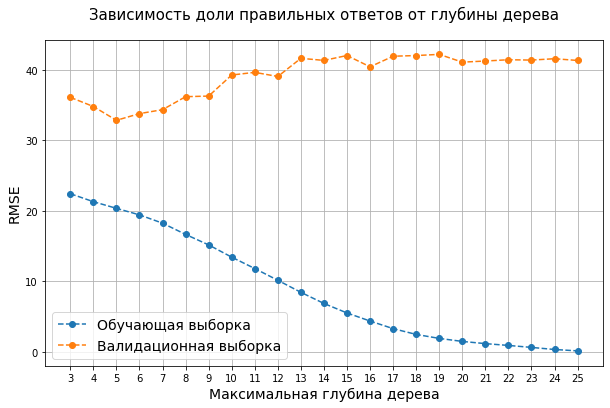

Алгоритм: DecisionTreeRegressor
Минимальная RMSE: 32.83
Самая удачная максимальная глубина: 5
CPU times: user 1.75 s, sys: 20 ms, total: 1.77 s
Wall time: 1.24 s


In [89]:
%%time
# переменные для сохранения наиболее удачных результатов
best_model_tree = None
best_depth = 0
best_mse = 100

# списки для построения графика зависимости результата от глубины дерева
results_train = []
results_valid = []
depths = []

# перебор параметров, обучение и выбор лучшей модели:
for depth in tqdm(range(3, 26)):
    # обучение модели на тренировочной выборке:
    model_tree =  DecisionTreeRegressor(random_state=1, max_depth=depth)
    model_tree.fit(x_train, y_train)
    # предсказания модели на обучающей выборке:
    predictions_train = model_tree.predict(x_train)
    # расчет mse на обучающей выборке:
    mse_train = mean_squared_error(y_train, predictions_train, squared=False)
    results_train.append(mse_train)
    # предсказания модели на валидационной выборке:
    predictions_valid = model_tree.predict(x_val)
    # расчет mse на валидационной выборке:
    mse_valid = mean_squared_error(y_val, predictions_valid, squared=False)
    results_valid.append(mse_valid)
    depths.append(depth)
    if mse_valid < best_mse:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_mse = mse_valid
# построение графика зависимости качества модели от максимальной глубины
pd.Series(index=depths, data=results_train).\
    plot(figsize=(10, 6), style='--o')
pd.Series(index=depths, data=results_valid).\
    plot(style='--o', grid=True)
plt.legend(['Обучающая выборка', 'Валидационная выборка'], fontsize=14)
plt.title('Зависимость доли правильных ответов от глубины дерева', pad=20, size=15)
plt.xlabel('Максимальная глубина дерева', size=14)
plt.ylabel('RMSE', size=14)
plt.xticks(ticks=range(3, 26))
plt.show()
get_report(model_name='DecisionTreeRegressor', best_mse=best_mse,
           best_depth=best_depth_tree)

### RandomForestRegressor

Ниже перебора гиперпараметров фактически нет, оставлены только наиболее удачные, чтобы обучение происходило быстрее.

In [90]:
# функция подбора гиперпараметров для случайного леса

def get_forest(x_train, y_train, x_test, y_test):
    
    # переменные для сохранения наиболее удачных результатов
    best_model_forest = None
    best_rmse = 100
    best_est = 0
    best_depth = 0

    # перебор параметров, обучение и выбор лучшей модели
    for est in tqdm(range(50, 61, 5)):
        for depth in range (5, 6):
            model_forest = RandomForestRegressor(random_state=1, 
                                              n_estimators=est, 
                                              max_depth=depth)
            # обучение модели на тренировочной выборке:
            model_forest.fit(x_train, y_train) 
            
            # предсказания модели на валидационной выборке:
            prediction = model_forest.predict(x_val) 
            
            # rmse валидационной выборке:
            rmse = mean_squared_error(y_val, prediction, squared=False)
            
            # сохранение параметров наилучшей модели
            if rmse < best_rmse:
                best_model_forest = model_forest
                best_rmse = rmse
                best_est = est
                best_depth = depth
    print("Средняя ошибка RandomForestRegressor - {:.0f}".format(best_rmse))
    print("Лучшее количество деревьев - {:.0f}".format(best_est))
    print("Лучшая глубина - {:.0f}".format(best_depth))

In [91]:
%%time
get_forest(x_train, y_train, x_val, y_val)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]

Средняя ошибка RandomForestRegressor - 31
Лучшее количество деревьев - 60
Лучшая глубина - 5
CPU times: user 1.22 s, sys: 8.01 ms, total: 1.23 s
Wall time: 1.22 s


## Тестирование

In [92]:
# объединение обучающей и валидационной выборки
x_train_full = pd.concat([x_train, x_val])
y_train_full = pd.concat([y_train, y_val]) 

In [93]:
%%time
model = LinearRegression()

model.fit(x_train_full, y_train_full)
prediction = model.predict(x_test)

print("Средняя ошибка LinearRegression: - {:.0f}".format(mean_squared_error(y_test, prediction, squared=False)))

Средняя ошибка LinearRegression: - 34
CPU times: user 30.4 ms, sys: 212 µs, total: 30.7 ms
Wall time: 11.9 ms


In [94]:
%%time
model = Ridge(alpha = 0)

model.fit(x_train_full, y_train_full)

prediction = model.predict(x_test)

print("Средняя ошибка SGDRegressor - {:.0f}".format(mean_squared_error(y_test, prediction, squared=False)))

Средняя ошибка SGDRegressor - 34
CPU times: user 48.2 ms, sys: 3.74 ms, total: 51.9 ms
Wall time: 12.6 ms


## Проверка на адекватность

In [95]:
# проверяем на адекватность моделью, которая будет предсказавать значение, равное предыдущему
dummy_prediction = pd.Series(y_test.shift(1))
# заполняем пропуск предыдущим значением
dummy_prediction.iloc[0] = y_train_full.iloc[-1]
# таргеты, "предсказанные" примитивной моделью
dummy_prediction = dummy_prediction.astype(int)
dummy_prediction

3823     45
3824     54
3825     91
3826    135
3827    155
       ... 
4243    207
4244    136
4245    154
4246    159
4247    223
Name: num_orders, Length: 425, dtype: int64

In [96]:
# истинные значения
y_test

3823     54
3824     91
3825    135
3826    155
3827    162
       ... 
4243    136
4244    154
4245    159
4246    223
4247    205
Name: num_orders, Length: 425, dtype: int64

In [97]:
print("Средняя ошибка Dummy-модели - {:.0f}".format(mean_squared_error(y_test, dummy_prediction, squared=False)))

Средняя ошибка Dummy-модели - 59


Средняя ошибка примитивной Dummy-модели, которая предсказывает значение, равное предыдущему - 59, что значительно выше допустимого значения ошибки и ошибок, полученных на линейных моделях. Следовательно, использование линейных моделей обоснованно.

## Выводы

Целью прокта было на основе данных о заказах такси с марта по сентябрь 2018 года построить модель прогнозирования количества заказов такси на следующий час со средней ошибкой не более 48 заказов.
____________


Предобработка данных в данном случае не понадобилась.

Временной ряд монотонный и приводимый к стационарному.

В среднем каждый час заказывали по 84 машины, за один час заказывали от 0 до 462 машин.

К концу периода (август-сентябрь) наблюдался значительный рост заказов: в среднем с 55 в марте до 160 заказов в час в конце августа. Пиковые нагрузки также пришлись на август.
___________


Для понимания заканомерностей и построения моделей были созданы новые признаки:

`sin_hour, cos_hour` - синус и косиеус часа

`dayofweek` - день недели

`month` - месяц

`lag_1`, `lag_2`, `lag_3` - предыдущие значения с отставанием на один, два, три часа соответственно

`rolling_mean_24` - скользящее среднее за последние 24 часа

`last_day` - количество заказов в прогнозируемый час в предыдущие сутки

`last_week` - количество заказов в целевой час на предыдущей неделе в тот же день

`last_days_mean` - среднее в целевой час за последние 3 дня

В среднем на количество заказов рказывают влияние следующие факторы:

- время суток

- день недели

- месяц (общий тренд)

- другие факторы.
____________


Были обучены и подобраны гиперпараметры для различных моделей регрессии со следующими результатами (RMSE) на валидационной выборке:

LinearRegression - 30

LGBMRegressor (с алгоритмами случайного леса и дерево решений с градинтным бустингом) - 32 и 31 соответственно

LGBMModel - 31

SGDRegressor - 31

Ridge - 30

DecisionTreeRegressor (макс. глубина 5) - 33

RandomForestRegressor (макс. глубина 5, кол-во деревьев 60) - 31.

В целом, на результаты обучения и качество предсказания большее влияние оказала подготовка признаков, чем подбор гиперпараметров.
_____________


По критерию минимизации ошибки RMSE и времени обучения и предсказания для тестирования были отобраны модели `LinearRegression` и `Ridge`. Ошибка RMSE на тестовой выборке для обеих моделей составила `34 заказа`, что удовлетворяет условиям задачи (менее 48 заказов). Время обучения и предсказания также аналогично для обеих моделей: 15-20 миллисекунд.

Проверка модели на адекватность проводилась сравнением с результатом примитивной (Dummy) модели, предсказывающей целевое значение равным предыдущему. Ошибка Dummy-модели оказалась равной 59, что значительно выше целевой и ошибки построенных ранее моделей. Следовательно, использование построенных ранее моделей эффективно и обоснованно.